In [1]:
from tqdm.autonotebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nlp = spacy.load('en_core_web_sm')
import string
import pandas as pd
import numpy as np
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop=stopwords.words('english')
exclude=set(string.punctuation)
from collections import defaultdict
from matplotlib import pyplot as plt

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1225/2713591869.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
from FightingWords.fighting_words_py3 import bayes_compare_language
from FightingWords.fighting_words_py3 import basic_sanitize

In [3]:
south_paper=['abbeville_banner','edgefield', 'nashville_union_american', 'daily_dispatch']
north_paper=['anti_slavery_bgule', 'national_era', 'green_mountain_freeman']
south_corpus_servant=[]
south_corpus_slave=[]
north_corpus_servant=[]
north_corpus_slave=[]
for i in tqdm(os.listdir('/Volumes/T7/chroniclingamerica/slavery/snippet-dedupe/'), desc='Loading data', position=0, leave=True):
    for k in south_paper:
        if i.startswith('dedupe_two_extended_'+k+'_servant'):
            servant=pd.read_csv('/Volumes/T7/chroniclingamerica/slavery/snippet-dedupe/'+i)
            south_corpus_servant.append(servant)
        elif i.startswith('dedupe_two_extended_'+k+'_slave'):
            slave=pd.read_csv('/Volumes/T7/chroniclingamerica/slavery/snippet-dedupe/'+i)
            south_corpus_slave.append(slave)
    for k in north_paper:
        if i.startswith('dedupe_two_extended_'+k+'_servant'):
            servant=pd.read_csv('/Volumes/T7/chroniclingamerica/slavery/snippet-dedupe/'+i)
            north_corpus_servant.append(servant)
        elif i.startswith('dedupe_two_extended_'+k+'_slave'):
            slave=pd.read_csv('/Volumes/T7/chroniclingamerica/slavery/snippet-dedupe/'+i)
            north_corpus_slave.append(slave)

Loading data: 100%|██████████| 47/47 [00:00<00:00, 255.18it/s]


In [4]:
south_servant=pd.concat(south_corpus_servant)
north_servant=pd.concat(north_corpus_servant)
south_slave=pd.concat(south_corpus_slave)
north_slave=pd.concat(north_corpus_slave)

In [5]:
file_names=os.listdir('/Volumes/T7/chroniclingamerica/slavery/raw-data')
file_name_text={}
for folder in tqdm(file_names, desc='Loading data', position=0, leave=True):
    if folder.startswith('.'):
        pass
    else:
        all_text=[]
        for file in os.listdir('/Volumes/T7/chroniclingamerica/slavery/raw-data/'+folder):
            if file.endswith('.txt'):
                with open('/Volumes/T7/chroniclingamerica/slavery/raw-data/'+folder+'/'+file, 'r', errors='replace') as f:
                    all_text.append(f.read())
                file_name_text[folder]=all_text

Loading data: 100%|██████████| 11/11 [00:04<00:00,  2.58it/s]


In [6]:
file_name_text.keys()

dict_keys(['daily_dispatch', 'national_era', 'abbeville_banner', 'edgefield_advertiser', 'anti_slavery_bugle', 'nashville_union_american', 'green_mountain_freeman'])

In [7]:
print(pd.DataFrame.from_dict(file_name_text['abbeville_banner']).shape)
print(pd.DataFrame.from_dict(file_name_text['anti_slavery_bugle']).shape)
print(pd.DataFrame.from_dict(file_name_text['daily_dispatch']).shape)
print(pd.DataFrame.from_dict(file_name_text['edgefield_advertiser']).shape)
print(pd.DataFrame.from_dict(file_name_text['national_era']).shape)
print(pd.DataFrame.from_dict(file_name_text['nashville_union_american']).shape)
print(pd.DataFrame.from_dict(file_name_text['green_mountain_freeman']).shape)

(1552, 1)
(2313, 1)
(14985, 1)
(2610, 1)
(2207, 1)
(10632, 1)
(6008, 1)


In [8]:
def lemmatization(dataframe:pd.DataFrame()):
    dataframe['context']=dataframe['context'].str.lower()
    dataframe['stopword']=dataframe['context'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    dataframe['punct']=dataframe['stopword'].str.replace('[^\w\s]','')
    dataframe['punct_stop']=dataframe['punct'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    dataframe['lemma']=dataframe['punct_stop'].apply(lambda row: ' '.join([w.lemma_ for w in nlp(row)]))
    dataframe['lemma_stop']=dataframe['lemma'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    dataframe['token']=dataframe['lemma_stop'].apply(word_tokenize)
    return dataframe

In [9]:
north_servant=lemmatization(north_servant)
north_slave=lemmatization(north_slave)
south_servant=lemmatization(south_servant)
south_slave=lemmatization(south_slave)

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1225/2331042617.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe['punct']=dataframe['stopword'].str.replace('[^\w\s]','')
/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1225/2331042617.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe['punct']=dataframe['stopword'].str.replace('[^\w\s]','')
/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1225/2331042617.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe['punct']=dataframe['stopword'].str.replace('[^\w\s]','')
/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1225/2331042617.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe['punct']=dataframe['stopword'].str.replace('[^\w\s]','')


In [10]:
slave=bayes_compare_language(north_slave['lemma_stop'], south_slave['lemma_stop'])
servant=bayes_compare_language(north_servant['lemma_stop'], south_servant['lemma_stop'])

Vocab size is 9809
Comparing language...
Vocab size is 3941
Comparing language...


In [11]:
slave_z_df=pd.DataFrame(slave, columns=['token', 'z-score'])
servant_z_df=pd.DataFrame(servant, columns=['token', 'z-score'])

In [12]:
slave_text=' '.join(north_slave['lemma_stop'])
slave_words=word_tokenize(slave_text)
servant_text=' '.join(north_servant['lemma_stop'])
servant_words=word_tokenize(servant_text)

In [13]:
frequency_slave=defaultdict(int)
for word in slave_words:
    frequency_slave[word]+=1
frequency_servant=defaultdict(int)
for word in servant_words:
    frequency_servant[word]+=1

In [14]:
frequency_list_slave=[]
for word in frequency_slave.keys():
    frequency_list_slave.append((word, frequency_slave[word]))
frequency_list_servant=[]
for word in frequency_servant.keys():
    frequency_list_servant.append((word, frequency_servant[word]))

In [15]:
slave_freq_df=pd.DataFrame(frequency_list_slave, columns=['token', 'frequency'])
servant_freq_df=pd.DataFrame(frequency_list_servant, columns=['token', 'frequency'])

In [16]:
slave_df=pd.merge(slave_z_df, slave_freq_df, on='token').sort_values(by='z-score', ascending=False)
servant_df=pd.merge(servant_z_df, servant_freq_df, on='token').sort_values(by='z-score', ascending=False)

In [17]:
slave_df['freq_ratio']=slave_df['frequency']/slave_df['frequency'].sum()
servant_df['freq_ratio']=servant_df['frequency']/servant_df['frequency'].sum()

In [18]:
servant_south_discourse=[
'vote', 'party', 'proslavery', 'whole', 'liberal', 'allegiance', 'commit', 'slavery', 'servile', 'last', 'arm', 'desire', 'owe', 'institution', 'measure', 'authority', 'prohibit', 'excitement', 'judge', 'like',
'table', 'moat', 'gentleman', 'ice', 'furniture', 'dry', 'superior', 'good', 'price', 'rood', 'reason', 'hoy', 'garden', 'summer', 'band', 'ladle', 'excellent', 'hood', 'children', 'dress',
'respectfully', 'obedient', 'friend', 'seat', 'john', 'announce', 'candidate', 'george', 'ensue', 'cook', 'house', 'james', 'jones', 'reelecton', 'abraham', 'representative', 'mar', 'scat', 'nominate', 'many',
'linen', 'good', 'bed', 'sound', 'shirt', 'dress', 'cook', 'excellent', 'train', 'mill', 'ticking', 'flannel', 'apron', 'cottonade', 'blanket', 'solicit', 'unusually', 'hue', 'coarse', 'men'
]

In [19]:
servant_north_discourse=[
'thy', 'lecture', 'wife', 'master', 'jesus', 'unto', 'song', 'mind', 'doctor', 'mother', 'child', 'mas', 'christ', 'husband', 'book', 'cony', 'away', 'obedient', 'bible', 'sin', 
'child', 'see', 'old', 'thy', 'girl', 'obedient', 'brother', 'day', 'mother', 'respectfully', 'live', 'good', 'woman', 'god', 'two', 'know', 'family', 'poor', 'wife', 'like', 
'obedient', 'thy', 'respectfully', 'god', 'brother', 'honor', 'christ', 'humble', 'bible', 'thou', 'heart', 'chain', 'unto', 'faithful', 'church', 'poor', 'girl', 'write', 'father', 'wife'
]

In [20]:
slave_south_discourse=[
'person', 'back', 'color', 'population', 'profit', 'say', 'upon', 'land', 'six', 'labor', 'nation', 'well', 'million', 'year', 'cause', 'owner', 'african', 'foreign', 'answer', 'also',
'carry', 'attempt', 'death', 'punishment', 'violation', 'crime', 'allege', 'protect', 'admit', 'suppose', 'district', 'commonwealth', 'matter', 'decision', 'marshal', 'concern', 'pro', 'prevent', 'account', 'resist',
'repeal', 'territory', 'law', 'prohibit', 'exclude', 'right', 'trade', 'north', 'fugitive', 'union', 'abolition', 'legislate', 'constitution', 'revive', 'exist', 'reopen', 'african', 'congress', 'foreign', 'carry',
'immediate', 'claim', 'would', 'favor', 'texas', 'maryland', 'proposition', 'pro', 'senator', 'justice', 'louisiana', 'piracy', 'beyond', 'attempt', 'effect', 'demand', 'especially', 'labor', 'intend', 'states',
]

In [21]:
slave_north_discourse=[
'restoration', 'entire', 'acquisition', 'demand', 'native', 'unconditional', 'enable' ,'stipulation', 'coastwise', 'throughout',' annex', 'internal', 'obtain', 'restore', 'uni',' suppression', 'aquiesce', 'piratical',' supremacy', 'defiance',
'territory', 'admission', 'admit', 'constitution',' prohibit', 'missouri', 'exclude', 'legislate', 'united', 'establish', 'limit','state','district', 'existence', 'exist', 'congress', 'free', 'prohibition', 'within', 'introduction', 
'gulf', 'oppose', 'favor', 'interested', 'virginia', 'immigration', 'transfer', 'derive', 'similar', 'emigration', 'impossible', 'annex', 'prevent', 'tennessee', 'gain', 'include', 'total', 'demand', 'interdict', 'encourage'
]

In [22]:
color_slave=[]
marker_slave=[]
for word in slave_df['token']:
    if ((word in slave_south_discourse) and (word not in slave_north_discourse)):
        color_slave.append('red')
        marker_slave.append('x')
    elif ((word not in slave_south_discourse) and (word not in slave_north_discourse)):
        color_slave.append('grey')
        marker_slave.append('v')
    elif ((word not in slave_south_discourse) and (word in slave_north_discourse)):
        color_slave.append('blue')
        marker_slave.append('o')
    elif ((word in slave_south_discourse) and (word in slave_north_discourse)):
        color_slave.append('green')
        marker_slave.append('D')

In [23]:
color_servant=[]
marker_servant=[]
for word in servant_df['token']:
    if ((word in servant_south_discourse) and (word not in servant_north_discourse)):
        color_servant.append('red')
        marker_servant.append('x')
    elif ((word not in servant_south_discourse) and (word not in servant_north_discourse)):
        color_servant.append('grey')
        marker_servant.append('v')
    elif ((word not in servant_south_discourse) and (word in servant_north_discourse)):
        color_servant.append('blue')
        marker_servant.append('o')
    elif ((word in servant_south_discourse) and (word in servant_north_discourse)):
        color_servant.append('green')
        marker_servant.append('D')

In [24]:
slave_df['color']=color_slave
slave_df['marker']=marker_slave
servant_df['color']=color_servant
servant_df['marker']=marker_servant

In [25]:
slave_viz_red=slave_df[slave_df['color']=='red']
slave_viz_blue=slave_df[slave_df['color']=='blue']
slave_viz_green=slave_df[slave_df['color']=='green']

In [26]:
servant_viz_red=servant_df[servant_df['color']=='red']
servant_viz_blue=servant_df[servant_df['color']=='blue']
servant_viz_green=servant_df[servant_df['color']=='green']

In [27]:
os.getcwd()

'/Users/mstudio/repository/discourse-slavery'

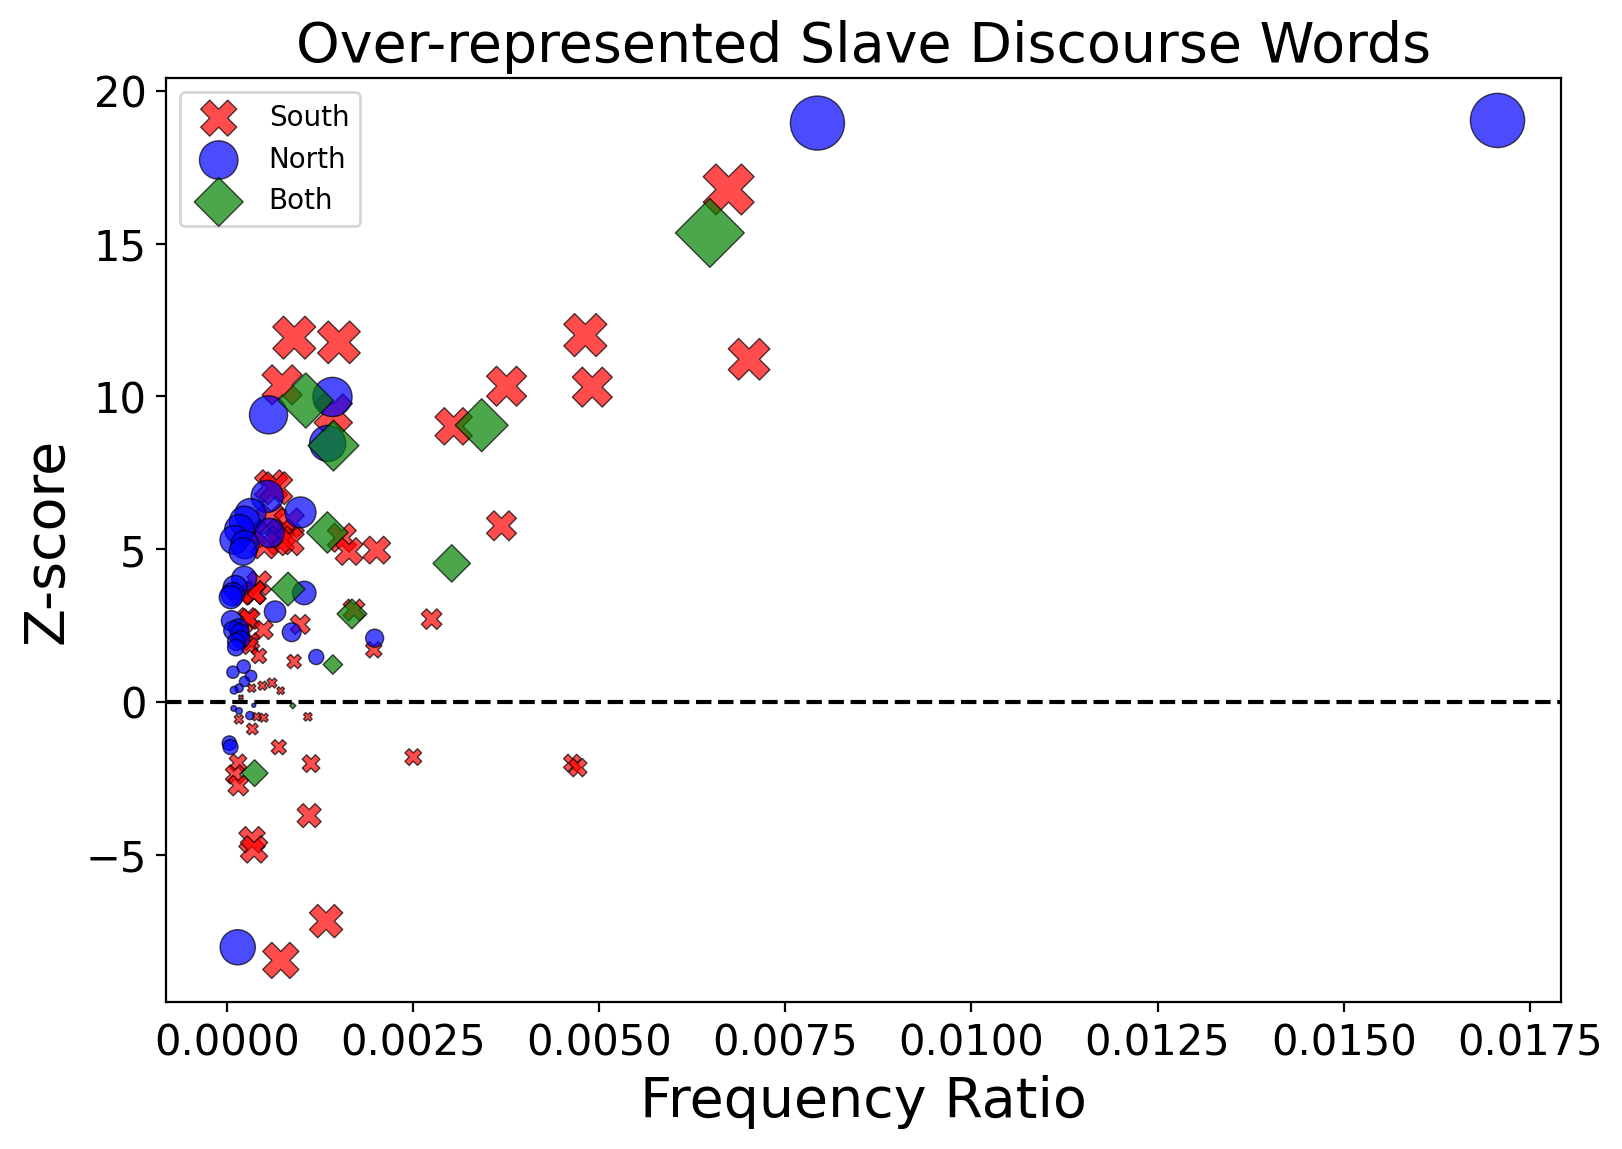

In [28]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=200)
south=plt.scatter(y=slave_viz_red['z-score'], x=slave_viz_red['freq_ratio'], 
           color=slave_viz_red['color'], alpha=0.7, s=abs(slave_viz_red['z-score'])*20,
            marker='X', edgecolors='black', linewidths=0.5)
north=plt.scatter(y=slave_viz_blue['z-score'], x=slave_viz_blue['freq_ratio'],
            color=slave_viz_blue['color'], alpha=0.7, s=abs(slave_viz_blue['z-score'])*20,
            marker='o', edgecolors='black', linewidths=0.5)
both=plt.scatter(y=slave_viz_green['z-score'], x=slave_viz_green['freq_ratio'],
            color=slave_viz_green['color'], alpha=0.7, s=abs(slave_viz_green['z-score'])*20,
            marker='D', edgecolors='black', linewidths=0.5)
ax.set_xlabel('Frequency Ratio', fontsize=20)
ax.set_ylabel('Z-score', fontsize=20)
ax.set_title('Over-represented Slave Discourse Words', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.legend((south, north, both),
        #    ('South', 'North', 'Both')),
ax.legend(handles=[south, north, both], 
          labels=['South', 'North', 'Both'])
ax.axhline(y=0.0005, color='black', linestyle='--')
plt.savefig('figure/slave-discourse.pdf')
plt.savefig('OUP General Template/figure/slave-discourse.pdf', dpi=200, bbox_inches='tight')
plt.show()

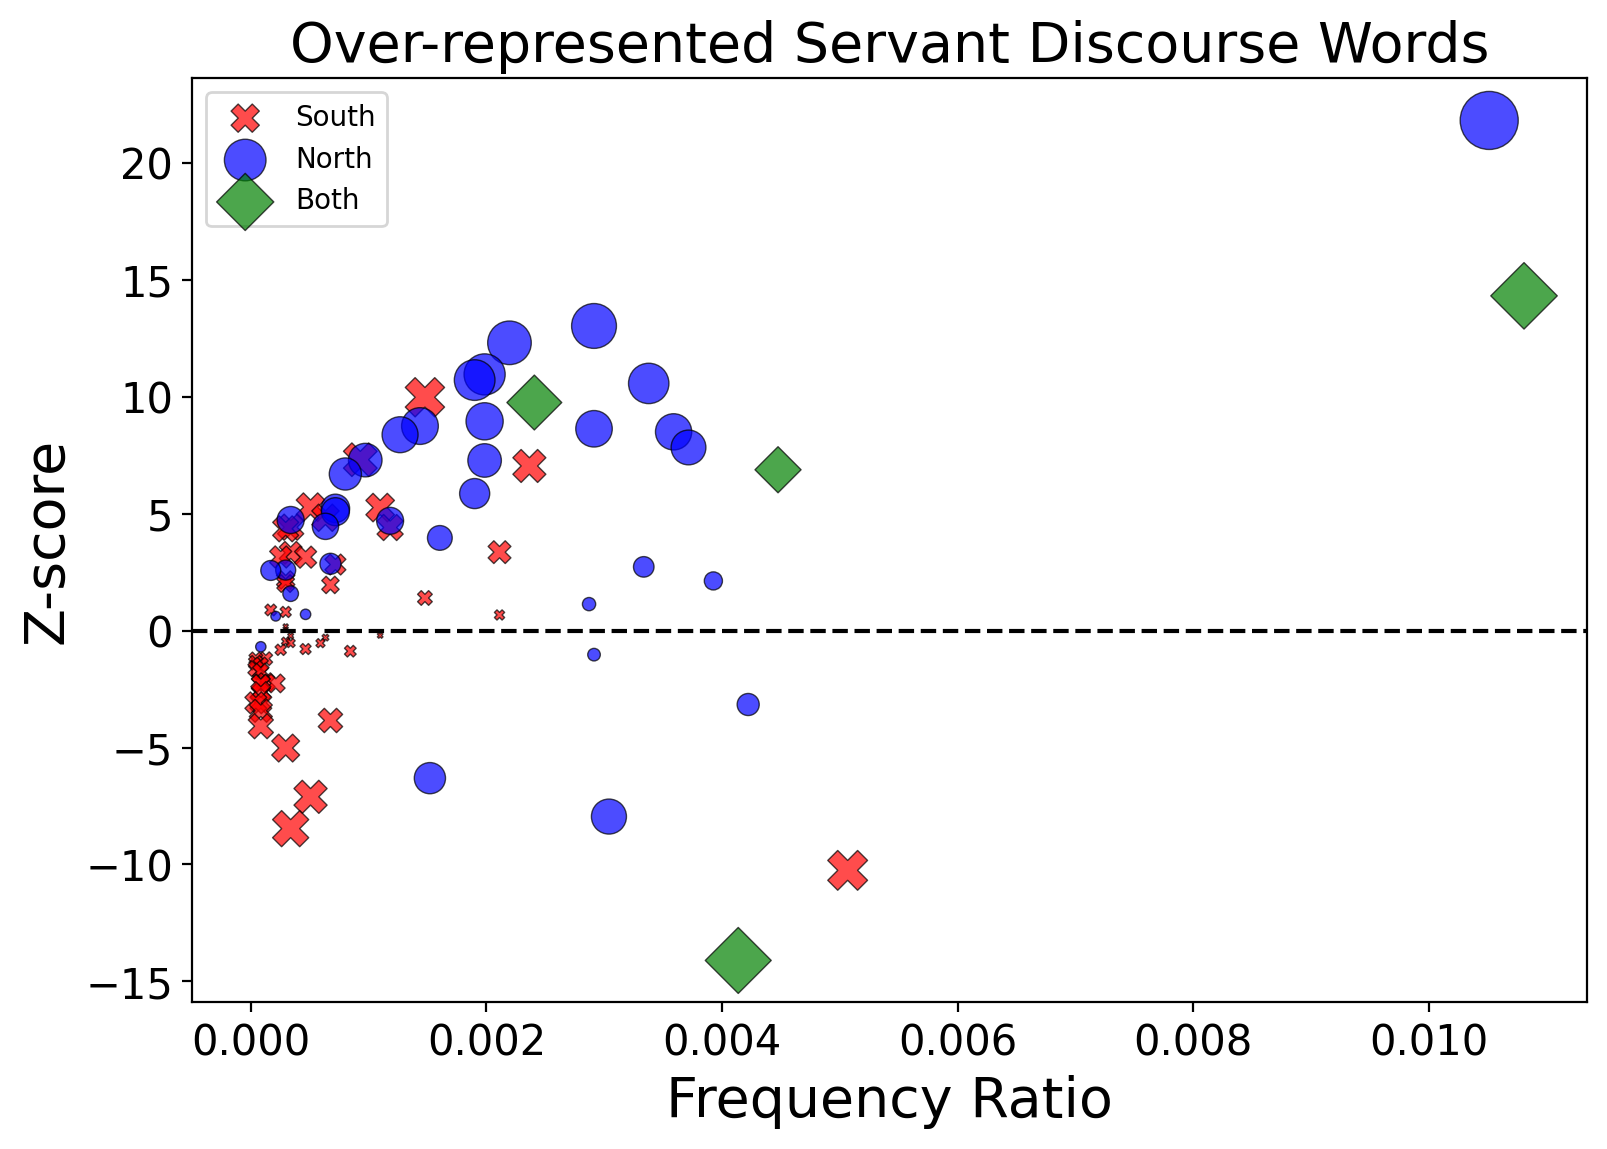

In [29]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=200)
south=plt.scatter(y=servant_viz_red['z-score'], x=servant_viz_red['freq_ratio'],
            color=servant_viz_red['color'], alpha=0.7, s=abs(servant_viz_red['z-score'])*20,
            marker='X', edgecolors='black', linewidths=0.5)
north=plt.scatter(y=servant_viz_blue['z-score'], x=servant_viz_blue['freq_ratio'],
            color=servant_viz_blue['color'], alpha=0.7, s=abs(servant_viz_blue['z-score'])*20,
            marker='o', edgecolors='black', linewidths=0.5)
both=plt.scatter(y=servant_viz_green['z-score'], x=servant_viz_green['freq_ratio'],
            color=servant_viz_green['color'], alpha=0.7, s=abs(servant_viz_green['z-score'])*20,
            marker='D', edgecolors='black', linewidths=0.5)
ax.set_xlabel('Frequency Ratio', fontsize=20)
ax.set_ylabel('Z-score', fontsize=20)
ax.set_title('Over-represented Servant Discourse Words', fontsize=20)
# plt.legend((south, north, both),
            #   ('South', 'North', 'Both')),
ax.legend(handles=[south, north, both], 
          labels=['South', 'North', 'Both'])
ax.axhline(y=0.0005, color='black', linestyle='--')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('figure/servant-discourse.pdf')
plt.savefig('OUP General Template/figure/servant-discourse.pdf', dpi=200, bbox_inches='tight')
plt.show()


In [35]:
slave_df.to_csv('output/slave_discourse.csv')
servant_df.to_csv('output/servant_discourse.csv')

In [41]:
print('Number of South slave discourse words over-represented in South', slave_df[(slave_df['color']=='red')&(slave_df['z-score']<0)].shape[0])
print('Number of South slave discourse words over-represented in North', slave_df[(slave_df['color']=='red')&(slave_df['z-score']>0)].shape[0])
print('Number of North slave discourse words over-represented in North', slave_df[(slave_df['color']=='blue')&(slave_df['z-score']>0)].shape[0])
print('Number of North slave discourse words over-represented in South', slave_df[(slave_df['color']=='blue')&(slave_df['z-score']<0)].shape[0])

Number of South slave discourse words over-represented in South 18
Number of South slave discourse words over-represented in North 45
Number of North slave discourse words over-represented in North 36
Number of North slave discourse words over-represented in South 7


In [55]:
print('Number of both slave disocurse words over-represented in North: ', slave_df[(slave_df['color']=='green')&(slave_df['z-score']>0)].shape[0])
print('Number of both slave disocurse words over-represented in South: ', slave_df[(slave_df['color']=='green')&(slave_df['z-score']<0)].shape[0])

Number of both slave disocurse words over-represented in North:  9
Number of both slave disocurse words over-represented in South:  2


In [42]:
print('Number of South servant discourse words over-represented in South', servant_df[(servant_df['color']=='red')&(servant_df['z-score']<0)].shape[0])
print('Number of South servant discourse words over-represented in North', servant_df[(servant_df['color']=='red')&(servant_df['z-score']>0)].shape[0])
print('Number of North servant discourse words over-represented in North', servant_df[(servant_df['color']=='blue')&(servant_df['z-score']>0)].shape[0])
print('Number of North servant discourse words over-represented in South', servant_df[(servant_df['color']=='blue')&(servant_df['z-score']<0)].shape[0])

Number of South servant discourse words over-represented in South 29
Number of South servant discourse words over-represented in North 23
Number of North servant discourse words over-represented in North 31
Number of North servant discourse words over-represented in South 5


In [56]:
print('Number of both servant disocurse words over-represented in North: ', servant_df[(servant_df['color']=='green')&(servant_df['z-score']>0)].shape[0])
print('Number of both servant disocurse words over-represented in South: ', servant_df[(servant_df['color']=='green')&(servant_df['z-score']<0)].shape[0])

Number of both servant disocurse words over-represented in North:  3
Number of both servant disocurse words over-represented in South:  1
